In [1]:
from collections import defaultdict
from os import listdir
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
import re
import pandas as pd
import matplotlib.pyplot as plt

### Use SpaCy tokenizer API to tokenize the text from the cleaned law corpus.

In [2]:
nlp = Polish()
tokenizer = nlp.tokenizer

In [3]:
def clean_text(line):
    line = re.sub(r"[^\w]", " ", line)
    line = re.sub(r"[0-9]", " ", line)
    line = re.sub(r"\br\b", " ", line)
    line = re.sub(r"\s\s+", " ", line)
    line = line.lower()
    return line

### Compute frequency list for each of the processed files

In [4]:
def get_freq_defaultdict(tokens):
    freq = defaultdict(int)
    for token in tokens:
        freq[token.text] += 1
    return freq

In [5]:
global_freq = defaultdict(int) #Aggregate the result to obtain one global frequency list.

for file in listdir("ustawy1"):
    with open(f'ustawy1/{file}', "r", encoding='utf-8') as f:
        content = f.read()
        tokens = tokenizer(clean_text(content))
        tokens = [token for token in tokens if not str(token).startswith('_') and len(token.text) >= 2] #Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish diacritics).
        doc_freq = get_freq_defaultdict(tokens)
        [global_freq.update({word: global_freq[word]+doc_freq[word]}) for word in doc_freq]
print(global_freq)

defaultdict(<class 'int'>, {'tekst': 329, 'ustawy': 13101, 'ustalony': 219, 'ostatecznie': 103, 'po': 13568, 'rozpatrzeniu': 154, 'poprawek': 222, 'senatu': 346, 'ustawa': 3235, 'dnia': 17955, 'maja': 804, 'zmianie': 1518, 'prawo': 4014, 'ochrony': 4606, 'środowiska': 3333, 'art': 83806, 'ustawie': 5478, 'kwietnia': 993, 'dz': 8888, 'nr': 44955, 'poz': 45245, 'wprowadza': 2001, 'się': 45887, 'następujące': 2276, 'zmiany': 4016, 'ust': 53640, 'zdanie': 678, 'wstępne': 118, 'otrzymuje': 9840, 'brzmienie': 10576, 'wpływy': 217, 'opłat': 1160, 'których': 17932, 'mowa': 28783, 'oraz': 33566, 'stycznia': 1896, 'recyklingu': 57, 'pojazdów': 493, 'wycofanych': 9, 'eksplo': 1, 'atacji': 1, 'powię': 1, 'kszo': 1, 'ne': 9, 'przychody': 515, 'oprocentowania': 260, 'na': 50665, 'rodowy': 1, 'fundusz': 1096, 'przez': 20956, 'nacza': 1, 'zastrzeżeniem': 2440, 'wyłącznie': 1439, 'dodaje': 8428, 'brzmieniu': 7295, 'narodowy': 269, 'za': 11188, 'zgodą': 608, 'ministra': 2713, 'właściwego': 3075, 'do': 6

### Make a plot in a logarithmic scale (for X and Y):

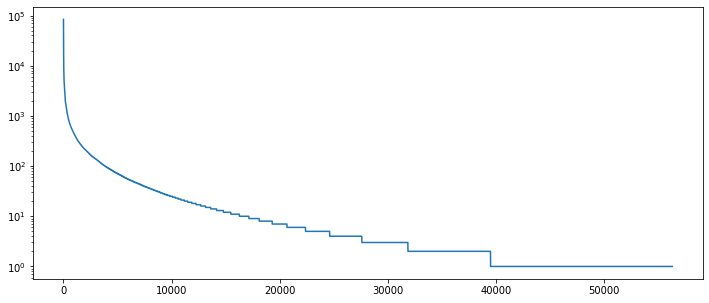

In [6]:
df = pd.DataFrame(global_freq.items(), columns=['word', 'count'])
df_sort = df.sort_values(['count', 'word'], ascending=[False, True]).reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(df_sort['count'])
plt.yscale("log")

### Install Morfeusz (Binding dla Pythona) and use it to find all words that do not appear in that dictionary.

In [7]:
pip install morfeusz2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import morfeusz2
morf = morfeusz2.Morfeusz()

### Sentymenty nieznane słownikowi otrzymują znacznik ign oraz lemat równy formie tekstowe ~ dokumentacja


In [9]:
morf.analyse('farmace')[0][2][2]

'ign'

In [10]:
df_sort['in_morf'] = df_sort['word'].apply(lambda row : False if morf.analyse(f'{row}')[0][2][2] == 'ign' else True)
df_sort

,word,count,in_morf
0,art,83806,True
1,do,60770,True
2,ust,53640,True
3,na,50665,True
4,się,45887,True
...,...,...,...
56284,żądany,1,True
56285,адвокат,1,False
56286,акушерка,1,False
56287,медицинска,1,False


In [11]:
not_in_morf = df_sort['word'][df_sort['in_morf']==False].reset_index(drop=True)
not_in_morf.to_csv('not_in_morf.csv', index=False)

### Find 30 words with the highest ranks that do not belong to the dictionary.

In [12]:
not_in_morf[:30].values

array(['poz', 'zm', 'późn', 'str', 'gmo', 'sww', 'operacyjno', 'skw',
       'rolno', 'ex', 'ike', 'społeczno', 'techniczno', 'remediacji',
       'ure', 'rozdz', 'itp', 'uke', 'kn', 'sanitarno', 'charytatywno',
       'np', 'cn', 'pkwiu', 'udt', 'bswsg', 'bswp', 'biobójczych',
       'organizacyjno', 'phs'], dtype=object)

### Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [13]:
df_sort = df_sort.sample(frac=1)

df_sort['word'][(df_sort['in_morf']==False) & (df_sort['count']>4)].reset_index(drop=True).sample(n = 30).values

array(['członkow', 'ratury', 'magnezowyc', 'inci', 'padku', 'tzw',
       'dzialności', 'słowno', 'nastawów', 'ią', 'ść', 'godz', 'windyka',
       'skw', 'rialnego', 'modakrylowych', 'cyjne', 'dydaktyczno',
       'postępo', 'nawozw', 'krotonyl', 'mgo', 'pkwiu', 'iiia',
       'difenylopropylo', 'disease', 'pomiarowo', 'tele', 'efrrow',
       'charytatywno'], dtype=object)

### Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from lists defined in points 8 and 9. (Note: You don't have to apply the distance directly. Any method that is more efficient than scanning the dictionary will be appreciated.)

In [14]:
pip install levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import numpy as np
from Levenshtein import distance

In [16]:
distance("farmace", "farmaceutycz")

5

In [17]:
in_morf = df_sort['word'][df_sort['in_morf']==True].reset_index(drop=True)

In [18]:
df1 = df_sort[['word', 'count']][df_sort['in_morf']==True].reset_index(drop=True)

In [7]:
point_8 = ['poz', 'zm', 'późn', 'str', 'gmo', 'sww', 'operacyjno', 'skw',
       'rolno', 'ex', 'ike', 'społeczno', 'techniczno', 'remediacji',
       'ure', 'rozdz', 'itp', 'uke', 'kn', 'sanitarno', 'charytatywno',
       'np', 'cn', 'pkwiu', 'udt', 'bswsg', 'bswp', 'biobójczych',
       'organizacyjno', 'phs']
point_9 = ['cn', 'etc', 'wo', 'organizacyjno', 'iib', 'eudravigilance',
       'dydaktyczno', 'uokik', 'jeeli', 'szcze', 'czących',
       'rozpuszczaln', 'betezda', 'ie', 'bswp', 'produktw', 'kśt',
       'syloe', 'teryto', 'torium', 'fep', 'publiczno', 'windyka', 'tj',
       'wodociągowo', 'nicznego', 'piran', 'najwyże', 'psychologiczno',
       'odpo']

def find_corrections(search_for):
    for word in search_for:
        min_distance = float('inf')
        min_word = []
        search = [ row for row in df1['word'].values if (row[0]==word[0]) or (row[-2:]==word[-2:]) ] 
        for correct_word in search:
            dist = distance(word, correct_word)
            if min_distance > dist or dist<3:
                min_distance = dist
                min_word=correct_word
        print(word, min_word)



In [21]:
find_corrections(point_8)

poz pro
zm zeń
późn pn
str sza
gmo grą
sww sza
operacyjno operacyjny
skw sza
rolno rolną
ex eta
ike ich
społeczno społecznego
techniczno technicznej
remediacji mediacji
ure urna
rozdz rodzi
itp ich
uke uli
kn kal
sanitarno sanitarne
charytatywno charytatywne
np not
cn cynk
pkwiu powie
udt usta
bswsg bursy
bswp bse
biobójczych zdobniczych
organizacyjno organizacyjne
phs pro


In [22]:
find_corrections(point_9)

cn cynk
etc etui
wo wodu
organizacyjno organizacyjne
iib imię
eudravigilance estryfikowane
dydaktyczno dydaktycznego
uokik unii
jeeli jeleni
szcze mecze
czących czających
rozpuszczaln rozpuszczalnej
betezda metoda
ie obie
bswp bse
produktw produktów
kśt kal
syloe sile
teryto tery
torium forum
fep fa
publiczno publiczność
windyka windy
tj tak
wodociągowo wodociągowe
nicznego liczonego
piran pianu
najwyże nadwyżce
psychologiczno psychologiczną
odpo odpad


### Load SGJP dictionary (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form) and use fuzzy matching to obtain the possible corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

In [2]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import streaming_bulk
import tqdm

In [3]:
es = Elasticsearch("http://localhost:9200",http_auth=('elastic', 'XTCeiO8mlhavlnHFW-6+'))

In [4]:
es.info()

/Users/wikip/opt/anaconda3/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


{'name': 'MacBook-Air-Wiktoria.local',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': '27Qbwpd9QtmbwN-YTUVOBA',
 'version': {'number': '7.17.6',
  'build_flavor': 'default',
  'build_type': 'tar',
  'build_hash': 'f65e9d338dc1d07b642e14a27f338990148ee5b6',
  'build_date': '2022-08-23T11:08:48.893373482Z',
  'build_snapshot': False,
  'lucene_version': '8.11.1',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

Create index

In [ ]:
response = es.indices.create(
    index="sgjp_pjn", 
    mappings={
        "properties": {
            "content": {
                "type": "text",
                "analyzer": "keyword"
            }
        }
    }
)

response

In [5]:
with open('sgjp.tab',encoding="utf8") as file:
    sgjp = [x.split("\t")[0] for x in file.read().split("\n")[28:]]

In [6]:
def generate_actions():

    for i,row in enumerate(sgjp):
        doc = {
            "_id": i,
            "content": row,
        }
        yield doc

In [ ]:
number_of_docs = len(sgjp)
progress = tqdm.tqdm(unit="docs", total=number_of_docs)
successes = 0
for ok, action in streaming_bulk(client=es, index="sgjp_pjn", actions=generate_actions(),):
    progress.update(1)
    successes += ok
print("Indexed %d/%d documents" % (successes, number_of_docs))

In [13]:
import requests

In [18]:
for word in point_8:
    response = requests.get(
        url="http://localhost:9200/sgjp_pjn/_search",
        json={
            "query": {
                "match": {
                    "content": {
                        "query": word,
                        "fuzziness": 2
                    }
                }
            }
        }
    ).json()
    corrs = [hit["_source"]["content"] for hit in response["hits"]["hits"]]
    corrs_str = ", ".join(corrs)
    print(word, corrs_str)

poz poz, Koz, Moz, Roz, doz, paz, paz, poć, pod, pod
zm zm, zm, em, em, hm, im, izm, km, om, im
późn późni, późno, późna, późna, późne, późne, późne, późne, późni, późno
str str, Otr, astr, itr, ser, sir, sir, star, ster, sto
gmo dmo, emo, emo, emo, emo, emo, emo, emo, emo, emo
sww siw, sów, suw, swa, swe, swe, swe, swe, swą, swą
operacyjno operacyjno, operacyjko, operacyjna, operacyjne, operacyjne, operacyjne, operacyjne, operacyjni, operacyjny, operacyjny
skw sakw, siw, ska, ski, sków, sów, suw, kw, Bokw, Dow
rolno rolno, Dolno, Kolno, Solno, dolno, kolno, polno, rodno, rojno, rojno
ex Rex, em, eś, ee, ef, ef, eh, ej, el, em
ike Mike, Mike, Mike, Mike, Nike, ikr, iks, iks, iks, ile
społeczno społeczno, aspołeczno, społeczna, społeczne, społeczne, społeczne, społeczne, społeczni, społeczny, społeczny
techniczno techniczno, techniczko, techniczna, techniczne, techniczne, techniczne, techniczne, techniczni, techniczny, techniczny
remediacji repudiacji, repudiacji, repudiacji, remediach,

In [19]:
for word in point_9:
    response = requests.get(
        url="http://localhost:9200/sgjp_pjn/_search",
        json={
            "query": {
                "match": {
                    "content": {
                        "query": word,
                        "fuzziness": 2
                    }
                }
            }
        }
    ).json()
    corrs = [hit["_source"]["content"] for hit in response["hits"]["hits"]]
    corrs_str = ", ".join(corrs)
    print(word, corrs_str)

cn ce, cen, ci, ck, ck, ck, ck, ck, ck, ck
etc etc, eta, eto, ety, ety, etą, etę, et, et, Ata
wo Ewo, Fo, Fo, Iwo, Iwo, Iwo, bo, bo, co, co
organizacyjno organizacyjno, organizacyjna, organizacyjne, organizacyjne, organizacyjne, organizacyjne, organizacyjni, organizacyjny, organizacyjny, organizacyjną
iib Cib, Gib, Gib, Lib, Lib, bib, iii, inb, izb, ii
eudravigilance 
dydaktyczno dydaktyczno, dydaktyczko, dydaktyczna, dydaktyczne, dydaktyczne, dydaktyczne, dydaktyczne, dydaktyczni, dydaktyczny, dydaktyczny
uokik Bobik, Bobik, Bokiń, Bokin, Bolik, Bolik, Bonik, Bonik, Copik, Copik
jeeli jedli, jedli, jedli, jeśli, jedli, jedli, jeźli, jeżeli, Adeli, Adeli
szcze czcze, czcze, czcze, czcze, sicze, sucze, sucze, sucze, sucze, sucze
czących clących, clących, czątych, czątych, oczących, oczących, uczących, uczących, Rzącach, Rzącach
rozpuszczaln rozpuszczalna, rozpuszczalne, rozpuszczalne, rozpuszczalne, rozpuszczalne, rozpuszczalni, rozpuszczalno, rozpuszczalny, rozpuszczalny, rozpuszczalną

### Compare results

### Draw conclusions regarding:


##### the distribution of words in the corpus,
Najczęściej występującymi tokenami w aktach są przyimki, słowa charakterystyczne dla aktów prawnych: ust, art itd. Najżadziej występującymi słowami są słowa w odmionionych formach a nawet i wyrażenia w języku obcym. 

##### the number of true misspellings vs. the number of unknown words,
Na przykładzie wypisanych przykładów:

['poz', 'zm', 'późn', 'str', 'gmo', 'sww', 'operacyjno', 'skw',
       'rolno', 'ex', 'ike', 'społeczno', 'techniczno', 'remediacji',
       'ure', 'rozdz', 'itp', 'uke', 'kn', 'sanitarno', 'charytatywno',
       'np', 'cn', 'pkwiu', 'udt', 'bswsg', 'bswp', 'biobójczych',
       'organizacyjno', 'phs']
       
['członkow', 'ratury', 'magnezowyc', 'inci', 'padku', 'tzw',
       'dzialności', 'słowno', 'nastawów', 'ią', 'ść', 'godz', 'windyka',
       'skw', 'rialnego', 'modakrylowych', 'cyjne', 'dydaktyczno',
       'postępo', 'nawozw', 'krotonyl', 'mgo', 'pkwiu', 'iiia',
       'difenylopropylo', 'disease', 'pomiarowo', 'tele', 'efrrow',
       'charytatywno']
Możemy zauważyć, żejednak więcej jest słów nieznanych słownikowi - słowa obce, słowa w odmianie które nie są zawarte w słowniku, skróty
Z błędów które najczęściej można dostrzec to nieprawidłowe podzielenie słowa na token- może to wynikać z umieszczenia spacji lub znaków specjalnych w słowie.
       
##### the performance of your method compared to ElasticSearch,

Moja metoda nie może się równać z ElasticSearch, nie przeszukuje co prawda całego słownika jednak czasowo ES był o wiele szybszy.

#####  the results provided by your method compared to ElasticSearch, the validity of the obtained corrections.

Moja metoda zwraca słowa które według odległości Lavensteina są najbliżej szukanego słowa, dlatego tez nie zawsze zwracane wyniki mają sens. Wyniki ES zawierają bardziej ogólne poprawki, ponieważ wykorzystano każde słowo ze słownika PJN, dzięki czemu mamy bazę słów z których możemy wybrac poprawną formę. 
